# Value Learning with Symbolic Regression

The objective of this paper is to learn representations of values from parametrized decisions and their evaluation made with human values in mind. 
We consider a tipical labeled dataset on some domain where input features represent a possibly desirable situation/decision parameters and the label is valued upon 2 or more classes representing (several) degrees of acceptability of the decision/situation.
 
Any supervised learning algorithm could optimize a model predicting the resulting degrees of acceptability from the input features with a high accuracy. However, we are not interested in learning such technical model, but the values that drive the prediction. To do so, we consider that higher degrees of acceptability represent a higher alignment with the value system of the situation evaluator/decision maker. Also, to certify we are learning a value system and not just a formula for the evaluation, we consider abstract value-related properties. These properties are defined by experts on input features and are assumedly relevant to characterize different values and concepts that conforming a preexistent high-level representation value system based on a taxonomical representation [Osman and D'Inverno et al. 2023](https://arxiv.org/abs/2305.02748). However, we only depart from unspecific clues around what properties are relevant to each concept, in the form of "Concept C is demoted by higher values of property P" or "Concept C is neutral by higher values of property P".

 Given that assumption, only based on the value-related properties we could train a model to predict the alignment of the value system.

The model and learning technique used is based on symbolic regression, constrained for semantic  

In [3]:
# Dependencies
import pandas as pd
import deap
import numpy as np
from scipy.stats import skew, kurtosis

# Preprocessing

In [4]:
# Data 
PATH_TRAIN = "../Datasets/CreditScore/train.csv"
PATH_TEST = "../Datasets/CreditScore/test.csv"

train = pd.read_csv(PATH_TRAIN)
test = pd.read_csv(PATH_TEST)
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()
train.columns

/var/folders/71/s2gcn01505x6ln1_t0g2pt0w0000gn/T/ipykernel_7918/3930975771.py:5: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(PATH_TRAIN)


Index(['id', 'customer_id', 'month', 'name', 'age', 'ssn', 'occupation',
       'annual_income', 'monthly_inhand_salary', 'num_bank_accounts',
       'num_credit_card', 'interest_rate', 'num_of_loan', 'type_of_loan',
       'delay_from_due_date', 'num_of_delayed_payment', 'changed_credit_limit',
       'num_credit_inquiries', 'credit_mix', 'outstanding_debt',
       'credit_utilization_ratio', 'credit_history_age',
       'payment_of_min_amount', 'total_emi_per_month',
       'amount_invested_monthly', 'payment_behaviour', 'monthly_balance',
       'credit_score'],
      dtype='object')

In [5]:
DISCLOSED = 'DISCLOSED_INFORMATION'
categorical_columns = ['credit_mix',
                      'month',
                      'occupation',
                      'payment_behaviour',
                      'payment_of_min_amount',
                      'type_of_loan',
                      'credit_score',
                      'id',
                      'customer_id',
                      'name',
                      'ssn']
class CategoricalTransformer():
    """
    This class provides methods for handling and transforming categorical features in a DataFrame.

    Parameters:
    - input_df (pd.DataFrame): The input DataFrame containing categorical features.

    Methods:
    - month_handling: Encodes and handles the 'month' column.
    - occupation_handling: Encodes and handles the 'occupation' column.
    - type_of_loan_handling: Handles and encodes the 'type_of_loan' column.
    - credit_mix_handling: Encodes and handles the 'credit_mix' column.
    - payment_of_min_amount_handling: Encodes and handles the 'payment_of_min_amount' column.
    - payment_behaviour_handling: Encodes and handles the 'payment_behaviour' column.
    - credit_score_handling: Encodes the 'credit_score' column.
    - column_deleter: Deletes unnecessary columns and returns the modified DataFrame.

    """
    def __init__(self,input_df:pd.DataFrame):
        self.df = input_df
    
    def month_handling(self) -> pd.DataFrame:
        if 'month' not in self.df.columns:
            raise ValueError ('"month" not found in the DataFrame.')
            
        
        self.df['month'] = self.df['month'].astype(str,errors='ignore')
        # Encoding without first value
        #month_dummies = pd.get_dummies(self.df['month'], prefix='month', drop_first=True, dtype=int)
        
        # Creating new dataframe with dummies (month_january) and without original column.
        # self.df = pd.concat([self.df, month_dummies], axis=1)
        #self.df.drop('month', axis=1, inplace=True)
        
        return self.df
        
    def occupation_handling(self) -> pd.DataFrame:
        if 'occupation' not in self.df.columns:
            raise ValueError ('"occupation" not found in the DataFrame.')
        
        # Deleting strange values
        self.df['occupation'] = self.df['occupation'].replace("_______", DISCLOSED)
        
        # Replacing missing values in each row, associated with a specific customer_id, with the most frequent value.
        """self.df['occupation'].astype(str)
        self.df['occupation'] = self.df.groupby('customer_id')['occupation'].transform(lambda x: x.mode()[0])"""
                
        # Binary encoding without first value.
        """occupation_dummies = pd.get_dummies(self.df['occupation'], drop_first=True, prefix='occupation', dtype=int)
        self.df = pd.concat([self.df, occupation_dummies], axis=1)
        self.df.drop('occupation', axis=1, inplace=True)"""
        
        return self.df
    
    def type_of_loan_handling(self) -> pd.DataFrame:
        '''
        There are values like "Credit-Builder Loan, and Mortgage Loan". Firs of all, this method extracts all 
        specific type of loans (Credit-Builder Loan,Mortgage Loan etc.). Then creates a columns like; "has_creadit_builder_loan".
        While creating these columns it checks if that specific loan type exist in the row then return true if exist or false
        if not. Finally, true and false values return zeros and ones and original column deleted.
        '''
                 
        if 'type_of_loan' not in self.df.columns:
            raise ValueError ('type_of_loan not found in the DataFrame.')

        loan_type_split = self.df['type_of_loan'].str.split(r', and |, | and |,').dropna()

        # Flatten the resulting list of lists
        loan_types_list = [item.strip() for sublist in loan_type_split.tolist() for item in sublist]

        # Geting the unique loan types
        unique_loan_types = set(loan_types_list)        

        
        for loan_type in unique_loan_types:    
            if pd.notna(loan_type):
                # Creating new columns without spaces but instead with "_"
                new_column = (loan_type.replace(" ", "_")).lower()
                
                # This line; created columns like "has_student_loan" and return true or false, if it's emtpy return pd.NA
                self.df[f'has_{new_column}'] = self.df['type_of_loan'].apply(lambda x: loan_type in x if pd.notna(x) else pd.NA)
                #This line; transforms true and false values into zeros and ones
                self.df[f'has_{new_column}'] = self.df[f'has_{new_column}'].apply(lambda x: int(x) if x is not pd.NA else x)

                # Filling null values with mode. Since these columns are binary, mode imputation has used to fill null values.
                mode_value = self.df[f'has_{new_column}'].mode().iloc[0]
                self.df[f'has_{new_column}'].fillna(mode_value, inplace=True)
        
        self.df.drop('type_of_loan', axis=1, inplace=True)
        
        return self.df
    
    def credit_mix_handling(self) -> pd.DataFrame:
        if 'credit_mix' not in self.df.columns:
            raise ValueError ('"credit_mix" not found in the DataFrame.')
        
        # Deleting strange values like "_"
        self.df['credit_mix'] = self.df['credit_mix'].replace("_", DISCLOSED)
        
        # Replacing missing values in each row, associated with a specific customer_id, with the most frequent value.
        """self.df['credit_mix']= self.df.groupby('customer_id')['credit_mix'].transform(lambda x: x.mode()[0])
        """
        self.df['credit_mix'].astype(str,errors="ignore")
        
        # Binary encoding
        """credit_mix_dummies = pd.get_dummies(self.df['credit_mix'], drop_first=True, prefix='credit_mix', dtype=int)
        self.df = pd.concat([self.df, credit_mix_dummies], axis=1)
        self.df.drop('credit_mix', axis=1, inplace=True)"""
        
        return self.df
    
    def payment_of_min_amount_handling(self) -> pd.DataFrame:
        if 'payment_of_min_amount' not in self.df.columns:
            raise ValueError ('"payment_of_min_amount" not found in the DataFrame.')
        
        # Deleting strange values like "NM"
        self.df['payment_of_min_amount'] = self.df['payment_of_min_amount'].replace("NM", DISCLOSED)
        
        # Replacing missing values in each row, associated with a specific customer_id, with the most frequent value.
        """self.df['payment_of_min_amount']= self.df.groupby('customer_id')['payment_of_min_amount'].transform(lambda x: x.mode()[0])"""
        self.df['payment_of_min_amount'].astype(str,errors="ignore")
        
        # Binary encoding
        """payment_of_min_amount_dummies = pd.get_dummies(self.df['payment_of_min_amount'],drop_first=True ,prefix='payment_of_min_amount', dtype=int)
        self.df = pd.concat([self.df, payment_of_min_amount_dummies], axis=1)
        self.df.drop('payment_of_min_amount', axis=1, inplace=True)"""
        
        return self.df
    
    def payment_behaviour_handling(self) -> pd.DataFrame:
        if 'payment_behaviour' not in self.df.columns:
            raise ValueError ('"payment_behaviour" not found in the DataFrame.')
        
        # Deleting strange values like "!@9#%8 "
        self.df['payment_behaviour'] = self.df['payment_behaviour'].replace("!@9#%8", DISCLOSED)
        
        # Replacing missing values in each row, associated with a specific customer_id, with the most frequent value.
        """self.df['payment_behaviour']= self.df.groupby('customer_id')['payment_behaviour'].transform(lambda x: x.mode()[0])"""
        self.df['payment_behaviour'].astype(str,errors="ignore")
        
        # Binary encoding
        """payment_behaviour_dummies = pd.get_dummies(self.df['payment_behaviour'],drop_first=True , dtype=int)
        self.df = pd.concat([self.df, payment_behaviour_dummies], axis=1)
        self.df.drop('payment_behaviour', axis=1, inplace=True)"""
        
        return self.df
    
    
    def credit_score_handling(self) -> pd.DataFrame:
        if 'credit_score' not in self.df.columns:
            raise ValueError ('"credit_score" not found in the DataFrame.')
            
        # After executing this method values will be Poor==-1, Good==1, Standard==0               
        mapping = {"Standard":0, "Poor":-1, "Good":1}
        self.df['credit_score'] = self.df['credit_score'].replace(mapping)
        
        # Since this column is the target variable, I expect it to be located at the end of the dataset.
        credit_score_column = self.df['credit_score']
        self.df = self.df.drop(columns=['credit_score'])
        self.df['credit_score'] = credit_score_column
        
        return self.df
    
    #THIS COLUMN SHOULD RUN IN THE END
    def column_deleter(self) -> pd.DataFrame:
       
        # All columns lowered one more time.
        self.df.columns = self.df.columns.str.lower()
        
        # Deleting unnecessary features.
        columns_to_drop = ['name', 'ssn', 'customer_id', 'id']
        self.df.drop(columns=columns_to_drop, inplace=True)
        
        
        return self.df
    
integer_columns_to_handle = ['age',
                            'num_bank_accounts',
                            'num_credit_card',
                            'interest_rate',
                            'num_of_loan',
                            'delay_from_due_date',
                            'num_of_delayed_payment',
                            'num_credit_inquiries',
                            'credit_history_age']

float_columns_to_handle = ['credit_utilization_ratio',
                           'annual_income',
                           'monthly_inhand_salary', 
                           'changed_credit_limit', 
                           'outstanding_debt', 
                           'total_emi_per_month',
                           'amount_invested_monthly', 
                           'monthly_balance']
class NumericTransformer():
    '''
    This class handles numeric features in a DataFrame. It provides methods for handling floating-point features,
    integer features, and transforming the 'credit_history_age' column.

    Parameters:
    - input_df (pd.DataFrame): The input DataFrame to be processed.

    Methods:
    - floats_handling: Handles floating-point features.
    - integers_handling: Handles integer features.
    - transform_credit_history_age: Transforms the 'credit_history_age' column.

    '''
    def __init__(self, input_df:pd.DataFrame):
        '''
        Initializes the NumericTransformer with the input DataFrame.

        Parameters:
        - input_df (pd.DataFrame): The input DataFrame to be processed.
        '''
        self.df = input_df
        self.df.columns = self.df.columns.str.lower()
        
    def floats_handling(self) -> pd.DataFrame:
        '''
        Handles floating-point features in the DataFrame.

        Returns:
        - pd.DataFrame: The DataFrame with processed floating-point features.
        '''
        columns_to_process = ['credit_utilization_ratio',
                           'annual_income',
                           'monthly_inhand_salary', 
                           'changed_credit_limit', 
                           'outstanding_debt', 
                           'total_emi_per_month',
                           'amount_invested_monthly', 
                           'monthly_balance']
        
        
        # First check if the specified columns exist in dataframe
        for column in columns_to_process:
            if column not in self.df.columns:
                raise ValueError(f"Column '{column}' not found in the DataFrame.")
         
        # Deleting specific strange values
        mapping = {'__-333333333333333333333333333__':DISCLOSED, 
                  '__10000__':DISCLOSED}
        self.df.replace(mapping, inplace=True)
        
        # Cleaning the datapoint from non-numeric characters.
        pattern = r'[^0-9.]' # Keeping numbers 0 to 9 and dots(".") because these are floats.
        for column in columns_to_process:
            self.df[column] = self.df[column].astype(str, errors="ignore") # All columns will be changed as str to impelement replace
            self.df[column] = self.df[column].str.replace(pattern, '', regex=True) # All characters gone except 0 to 9 and dot
            self.df[column] = self.df[column].replace('', DISCLOSED) # After deleting characters some rows could be emtpy, they're NA now
        
        
        ## FILLING MISSING ROWS ##
        # Mode imputation will be applied to some features and mean will be applied to others(last 2)
        
        # Imputing columns except first and last three.
        for mode_column in columns_to_process[1:-3]:
            self.df[mode_column] = self.df.groupby('customer_id')[mode_column].transform(lambda x: x.mode()[0])           
            
            
        ### columns_to_process[5]/'total_emi_per_month' has 0 values so it will be treated separately ###
        # Converting float to be able to apply imputations.
        self.df['total_emi_per_month']= (self.df['total_emi_per_month'].astype(float,errors="ignore")).round(4)
        
        # Implementing mode imputation to non-null values.
        self.df['total_emi_per_month'] = self.df.groupby('customer_id')['total_emi_per_month'].transform(lambda x: x.mode()[0] if not x.isnull().all() else pd.NA)          
        
        # There are so many zeros and they're not valid. Replacing(deleting) zeros with pd.NA then mean imputing to missing rows.
        self.df['total_emi_per_month'] = self.df['total_emi_per_month'].replace(0, DISCLOSED)
        #self.df['total_emi_per_month'].fillna(self.df['total_emi_per_month'].median(), inplace=True)

        
        
        ## Imputation of last two features; amount_invested_monthly, monthly_balance ##
        # There will be mean imputation for these two column
        # total_emi_per_month =  Skewness: 2.55, Kurtosis: 8.74
        # monthly_balance = Skewness: 1.59, Kurtosis: 2.95
        for mean_column in columns_to_process[-2:]:            
            # Converting the column to a numeric data type, handling non-numeric values
            self.df[mean_column] = pd.to_numeric(self.df[mean_column], errors='coerce')
            # Filling missing values with the mean
            #self.df[mean_column] = self.df[mean_column].fillna(self.df[mean_column].mean())
            self.df[mean_column] = self.df[mean_column].fillna(DISCLOSED)
        # All columns will be float data type.
        self.df[columns_to_process] = self.df[columns_to_process].astype(float,errors="ignore").round(4)
            
        return self.df
       
        
    def integers_handling(self) -> pd.DataFrame:
        '''
        Handles integer features in the DataFrame.

        Returns:
        - pd.DataFrame: The DataFrame with processed integer features.
        '''
        features_to_process = ['age',                            
                              'num_credit_card',
                              'interest_rate',
                              'delay_from_due_date',
                              'num_of_delayed_payment',
                              'num_of_loan',
                              'num_bank_accounts',
                              'num_credit_inquiries'
                              ]
        
        
        # First check if the specified columns exist in dataframe
        for column in features_to_process:
            if column not in self.df.columns:
                raise ValueError(f"Column '{column}' not found in the DataFrame.")
            


        pattern = r'[^0-9]'
        for column in features_to_process:
            self.df[column] = self.df[column].astype(str,errors="ignore") # All columns will be changed as str to ne able to impelement replace
            self.df[column] = self.df[column].str.replace(pattern, '', regex=True) # All characters gone except 0 to 9 
            self.df[column] = self.df[column].replace('', DISCLOSED) #After deleting characters some rows could be emtpy, they're NA now

            # Replacing missing values in each row, associated with a specific customer_id, with the most frequent value.
            #self.df[column] = self.df.groupby('customer_id')[column].transform(lambda x: x.mode()[0])
            # Tranformed as int.
            self.df[column] = self.df[column].astype(int,errors="ignore")
            
            
        #So many invalid zeros, they need to be handled (last three values in features_to_process).
        for column in features_to_process[-3:]:
            
            # I dont remember why I implemented this line of code twice but I am gonna keep it :)
            #self.df[column] = self.df.groupby('customer_id')[column].transform(lambda x: x.mode()[0] if not x.isnull().all() else pd.NA)
            self.df[column] = self.df.groupby('customer_id')[column].transform(lambda x: x.mode()[0] if not x.isnull().all() else DISCLOSED)
            # Replacing zeros with pd.NA then implementing mean imputation.
            self.df[column] = self.df[column].replace(0, DISCLOSED)
            #self.df[column].fillna(self.df[column].median(), inplace=True)
            self.df[column] = self.df[column].astype(int,errors="ignore")

            
        return self.df
            
            
            
    def transform_credit_history_age(self) -> pd.DataFrame:
        '''
        Transforms the 'credit_history_age' column from textual format to integer format
        (e.g., 3 Years and 1 Month to 37)

        Returns:
        - pd.DataFrame: The DataFrame with the transformed 'credit_history_age' column.
        '''
        column_name = 'credit_history_age'

        # There are few kinds of null types so I replaced all of them with pd.NA
        self.df[column_name] = self.df[column_name].fillna(pd.NA)

        # Replacing missing values in each row, associated with a specific customer_id, with the most frequent value.
        self.df[column_name] = self.df.groupby('customer_id')[column_name].transform(lambda x: x.mode()[0] if not x.isnull().all() else DISCLOSED)

        # Converting the column to string type
        self.df[column_name] = self.df[column_name].astype(str,errors="ignore")

        # Extracting the numeric values using regular expressions
        extracted_values = self.df[column_name].str.extract(r'(\d+) Years and (\d+) Months')

        # Converting the extracted values to integers and perform the calculation.
        self.df[column_name] = (extracted_values[0].astype(int) * 12) + extracted_values[1].astype(int)

        return self.df
    
numeric_columns = integer_columns_to_handle + float_columns_to_handle
class Preprocessor():
    '''
    A utility class to perform transformations on a DataFrame.
    '''
    def __init__(self, dataframe:pd.DataFrame):
        '''
        Initializes numeric and categorical transformes.
        
        Paramaters:
        - dataframe(pd.DataFrame): The input DataFrame to be transformed
        '''
        
        # Creating copy of original dataframe
        self.df = dataframe.copy()
         
        # Creating instances of transformers.    
        self.num_handler = NumericTransformer(input_df=self.df)
        self.cat_handler = CategoricalTransformer(input_df=self.df)

        
    def transform(self) -> pd.DataFrame:

        # Numeric transformation
        self.df = self.num_handler.floats_handling()
        self.df = self.num_handler.integers_handling()
        self.df = self.num_handler.transform_credit_history_age()

        # Categorical transformation
        self.df = self.cat_handler.credit_mix_handling()
        self.df = self.cat_handler.month_handling()
        self.df = self.cat_handler.occupation_handling()
        self.df = self.cat_handler.payment_behaviour_handling()
        self.df = self.cat_handler.payment_of_min_amount_handling()
        self.df = self.cat_handler.type_of_loan_handling()
        self.df = self.cat_handler.credit_score_handling()
        self.df = self.cat_handler.column_deleter()

        

        return self.df
    

In [6]:
preprocessor = Preprocessor(dataframe=train)
prep_train = preprocessor.transform() # Creating a new transformed dataframe

In [7]:
def disclosedTypes(origdf):
        for pr in origdf.columns:
            print(origdf[pr].dtype)
            if origdf[pr].dtype == object:
                origdf[pr] = origdf[pr].apply(lambda x: str(x) if not pd.isna(x) else DISCLOSED) 
                origdf[pr] = origdf[pr].astype('string')
                print(origdf[pr].dtype)
        return origdf
prep_train = disclosedTypes(prep_train)

object
string
int64
object
string
float64
object
string
object
string
int64
int64
object
string
int64
object
string
float64
int64
object
string
float64
float64
int64
object
string
object
string
object
string
object
string
object
string
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64


In [8]:
prep_train.sample(10)
prep_train.dtypes


month                          string[python]
age                                     int64
occupation                     string[python]
annual_income                         float64
monthly_inhand_salary          string[python]
num_bank_accounts              string[python]
num_credit_card                         int64
interest_rate                           int64
num_of_loan                    string[python]
delay_from_due_date                     int64
num_of_delayed_payment         string[python]
changed_credit_limit                  float64
num_credit_inquiries                    int64
credit_mix                     string[python]
outstanding_debt                      float64
credit_utilization_ratio              float64
credit_history_age                      int64
payment_of_min_amount          string[python]
total_emi_per_month            string[python]
amount_invested_monthly        string[python]
payment_behaviour              string[python]
monthly_balance                str

In [9]:
class FeatureAnalyzer():
    '''
    This class provides methods to analyze numerical columns in a DataFrame, including statistics such as mean,
    median, standard deviation, variance, kurtosis, skewness, maximum, minimum, and count of zeros.

    Args:
        input_df (pd.DataFrame): The DataFrame containing the numerical columns to be analyzed.

    Methods:
        column_statistics(columns): Calculates statistics for the specified columns.

    '''
    def __init__(self, input_df):
        self.df = input_df

    def column_statistics(self, columns):
        '''
        Calculate statistics for the specified columns.

        Args:
            columns (list of str): A list of column names to analyze.

        Returns:
            pd.DataFrame: A DataFrame containing statistics for the specified columns.

        Example:
            analyzer = FeatureAnalyzer(data_frame)
            stats = analyzer.column_statistics(['age', 'income'])
        '''
        
        invalid_columns = [col for col in columns if col not in self.df.columns]
        if invalid_columns:
            print("Invalid columns:", invalid_columns)
            return
        
        stats_dict = {}
        
        for column in columns:
            # Replace non-numeric values with NaN
            numeric_values = pd.to_numeric(self.df[column].dropna(), errors='coerce')
            
            count_of_zeros = (numeric_values == 0).sum()
            std = numeric_values.std()
            variance = numeric_values.var()
            mean = numeric_values.mean()
            median = numeric_values.median()
            #kurt = kurtosis(numeric_values).round(2)
            #skewness = skew(numeric_values).round(2)
            maximum = numeric_values.max()
            minumum = numeric_values.min()            
            
            stats_dict[column] = {
                'Count of Zeros': count_of_zeros,
                'Standard Deviation': std,
                'Variance': variance,
                'Mean': mean,
                'Median': median,
                #'Kurtosis': kurt,
                #'Skewness': skewness,
                'Max Value': maximum,
                'Min Value': minumum                
            }
            
        return pd.DataFrame.from_dict(stats_dict, orient='index')

In [10]:
analyzer2 = FeatureAnalyzer(input_df=prep_train)
analyzer2.column_statistics(numeric_columns)

,Count of Zeros,Standard Deviation,Variance,Mean,Median,Max Value,Min Value
age,0,684.757313,4.688926e+05,119.509700,34.000000,8698.000000,14.000000
num_bank_accounts,0,2.376203,5.646339e+00,5.614123,6.000000,10.000000,1.000000
num_credit_card,13,129.057410,1.665582e+04,22.474430,5.000000,1499.000000,0.000000
interest_rate,0,466.422621,2.175501e+05,72.466040,13.000000,5797.000000,1.000000
num_of_loan,0,2.222863,4.941121e+00,3.987809,4.000000,9.000000,1.000000
delay_from_due_date,1195,14.822802,2.197155e+02,21.095040,18.000000,67.000000,0.000000
num_of_delayed_payment,1609,226.028754,5.108900e+04,30.946268,14.000000,4397.000000,0.000000
num_credit_inquiries,7504,38.760427,1.502371e+03,57.284800,50.000000,170.000000,0.000000
credit_history_age,0,99.580975,9.916371e+03,220.156240,216.000000,397.000000,1.000000
credit_utilization_ratio,0,5.116875,2.618241e+01,32.285173,32.305800,50.000000,20.000000


# Fitter

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,0.003508,2401.650325,2439.411658,inf,0.067737,0.0
norm,0.005109,2829.670061,2848.550728,inf,0.146231,0.0
burr,0.005953,1553.563355,1591.324688,inf,0.089365,0.0
gamma,0.020595,1206.542899,1234.863899,inf,0.239653,0.0
lognorm,0.043306,1829.360579,1857.681579,inf,0.525434,0.0


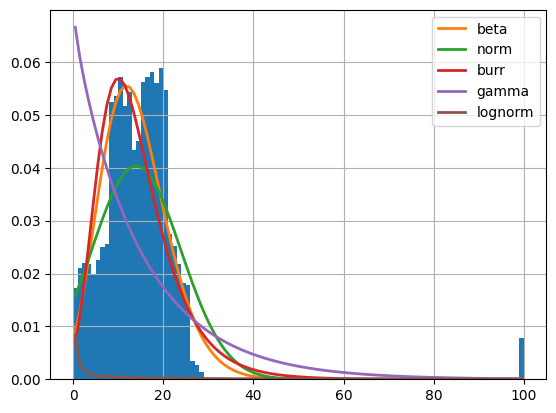

In [11]:
import matplotlib
from fitter import Fitter
f = Fitter(prep_train['num_of_delayed_payment'][lambda x: (x != DISCLOSED)].apply(lambda x: min(int(x), 100)),
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"], bins=100,density=False)
f.fit()
f.summary()

{'gamma': {'a': 2.095427887543851, 'loc': -1.1080645351318217, 'scale': 10.595981365886662}}


(8.0, 30.0)

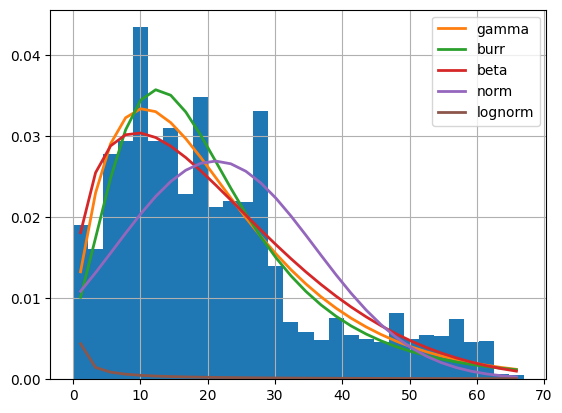

In [12]:
import matplotlib
from fitter import Fitter
#ax = prep_train['delay_from_due_date'].plot.hist(bins=30)

f = Fitter(prep_train['delay_from_due_date'],
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"], bins=30,density=False)
f.fit()
f.summary()

delay_due_date_distribution = f.get_best()
print(delay_due_date_distribution)

percentile_80 = np.percentile(prep_train['delay_from_due_date'], 80)
percentile_20 = np.percentile(prep_train['delay_from_due_date'], 20)
percentile_20, percentile_80

# Defining the properties

In [13]:
prep_train["monthly_balance"]

0        312.49408867943663
1        284.62916249607184
2         331.2098628537912
3        223.45130972736783
4        341.48923103222177
                ...        
99995    479.86622816574095
99996      496.651610435322
99997     516.8090832742814
99998     319.1649785257098
99999     393.6736955618808
Name: monthly_balance, Length: 100000, dtype: string

In [14]:
prep_train['annual_income']

0        19114.12
1        19114.12
2        19114.12
3        19114.12
4        19114.12
           ...   
99995    39628.99
99996    39628.99
99997    39628.99
99998    39628.99
99999    39628.99
Name: annual_income, Length: 100000, dtype: float64

In [15]:
prep_train.columns

Index(['month', 'age', 'occupation', 'annual_income', 'monthly_inhand_salary',
       'num_bank_accounts', 'num_credit_card', 'interest_rate', 'num_of_loan',
       'delay_from_due_date', 'num_of_delayed_payment', 'changed_credit_limit',
       'num_credit_inquiries', 'credit_mix', 'outstanding_debt',
       'credit_utilization_ratio', 'credit_history_age',
       'payment_of_min_amount', 'total_emi_per_month',
       'amount_invested_monthly', 'payment_behaviour', 'monthly_balance',
       'has_not_specified', 'has_auto_loan', 'has_credit-builder_loan',
       'has_mortgage_loan', 'has_student_loan', 'has_home_equity_loan',
       'has_debt_consolidation_loan', 'has_personal_loan', 'has_payday_loan',
       'credit_score'],
      dtype='object')

In [16]:


for column_name in categorical_columns:
      if column_name != 'type_of_loan' and column_name in prep_train.columns:
            print(prep_train[column_name].unique())

<StringArray>
['DISCLOSED_INFORMATION', 'Good', 'Standard', 'Bad']
Length: 4, dtype: string
<StringArray>
['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August']
Length: 8, dtype: string
<StringArray>
[            'Scientist', 'DISCLOSED_INFORMATION',               'Teacher',
              'Engineer',          'Entrepreneur',             'Developer',
                'Lawyer',         'Media_Manager',                'Doctor',
            'Journalist',               'Manager',            'Accountant',
              'Musician',              'Mechanic',                'Writer',
             'Architect']
Length: 16, dtype: string
<StringArray>
[ 'High_spent_Small_value_payments',   'Low_spent_Large_value_payments',
  'Low_spent_Medium_value_payments',   'Low_spent_Small_value_payments',
 'High_spent_Medium_value_payments',            'DISCLOSED_INFORMATION',
  'High_spent_Large_value_payments']
Length: 7, dtype: string
<StringArray>
['No', 'DISCLOSED_INFORMATION', 'Yes']


We consider the following concepts:

1. Value System
    1. Stimulation  
        1. P1: Presence of stimulating topics (additive point based (MAYBE agregar logicamente)) (PROPORTIONAL):
            ```
            {
                'has_debt_consolidation_loan': 1, 
                'has_mortgage_loan': 2,
                'has_credit-builder_loan': 2, 
                'has_not_specified': 0, 
                'has_student_loan': 4,
                'has_auto_loan': 1, 
                'has_home_equity_loan': 0, 
                'has_personal_loan': 2,
                'has_payday_loan': 0
            }
            accept_p1 = P1 >= 6
            ```
        1. Stimulating profile
            1. P2: Job stimuli Entrepeneur (10) Scientist (9) Architect (7) Engineer (5) rest (1) Disclosed 0 (PROPORTIONAL).
            1. P3: Age of applicant (INVERSELY MONOTONIC)
            1. P4: Has high spent profile, whatever value payments, exactly (1 is favor, 0 neutral, -1 against stimulus):
            ```
            {
                'High_spent_Small_value_payments': 1,
                'Low_spent_Large_value_payments': -1,
                'Low_spent_Medium_value_payments': -1,
                'Low_spent_Small_value_payments': 0,
                'High_spent_Medium_value_payments': 1,
                'High_spent_Large_value_payments': 1,
                'DISCLOSED': 0
            }
            ```
    2. Benevolence:
        1. Monetary need
            1. P5: annual_income (inversely proportional)
            1. P6: monthly_balance (inversely proportional)
        1. P7: Has low spent profile, whatever value payments
            ```
            {
                'High_spent_Small_value_payments': -1,
                'Low_spent_Large_value_payments': 1,
                'Low_spent_Medium_value_payments': 1,
                'Low_spent_Small_value_payments': 1,
                'High_spent_Medium_value_payments': -1,
                'High_spent_Large_value_payments': -1,
                'DISCLOSED': 0
            }
            ``` 
    3. Security:
        1. Profile
            1. P8: Has safe profile
            ```
            {
                'High_spent_Small_value_payments': -1,
                'Low_spent_Large_value_payments': 1,
                'Low_spent_Medium_value_payments': 0.75,
                'Low_spent_Small_value_payments': 0.5,
                'High_spent_Medium_value_payments': -0.5,
                'High_spent_Large_value_payments': 0,
                'DISCLOSED': 0
            }
            ``` 
            1. P9: Amount invested (inversely proportional)
        1. Payment conduct
            1. P10: payment_of_min_amount (Yes -> 1, No -> -1, DISCLOSED: 0)
            1. P11: delay_from_due_date
            1. P12: num_of_delayed_payments 
        1. P13: Secure topics:
            ```
            {
                'has_debt_consolidation_loan': 5, 
                'has_mortgage_loan': 4,
                'has_credit-builder_loan': 0, 
                'has_not_specified': 0, 
                'has_student_loan': 2,
                'has_auto_loan': 1, 
                'has_home_equity_loan': 3, 
                'has_personal_loan': 3,
                'has_payday_loan': -1
            }
            ```

In [48]:
def aggregate_points(row, vals, op=np.sum):
        ret = 0
        for col, val in vals.items():
            if row[col] == 1:
                ret = np.sum([ret, val])
        return ret

class PreferenceObject(object):
    def __init__(self, df: pd.DataFrame, dft: pd.DataFrame, props = ['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13']):
        self.df = df
        self.dft = dft
        self.props = props
        self.percentile_high = {}
        self.percentile_low = {}
    def accept_p1(self, val):
        return val >= 6
    def unaccept_p1(self, val):
        return val < 3
    def generate_p1(self): 
        vals = {
                    'has_debt_consolidation_loan': 1, 
                    'has_mortgage_loan': 2,
                    'has_credit-builder_loan': 2, 
                    'has_not_specified': 0, 
                    'has_student_loan': 4,
                    'has_auto_loan': 1, 
                    'has_home_equity_loan': 0, 
                    'has_personal_loan': 2,
                    'has_payday_loan': 0
                }
        
        return self.df.apply(lambda row: aggregate_points(row, vals), axis=1)
    def accept_p2(self,val):
        return val >= 7
    def unaccept_p2(self,val):
        return val <= 1
    def generate_p2(self):
        return self.df.apply(lambda row: (10 if row['occupation'] == 'Entrepeneur'
                        else 9 if row['occupation'] == 'Scientist'
                        else 5 if row['occupation'] == 'Engineer' 
                        else 7 if row['occupation'] == 'Architect' else 1) if not pd.isna(row['occupation']) else 0, axis=1)
    def accept_p3(self,val):
        return val <= 30
    def unaccept_p3(self,val):
        return val >= 50
    def generate_p3(self
                    ):
        return self.df.apply(lambda row: row['age'], axis=1)

    def accept_p4(self,val):
        return val == 1
    def unaccept_p4(self,val):
        return val == -1
    def generate_p4(self):
        ref = {
                    'High_spent_Small_value_payments': 1,
                    'Low_spent_Large_value_payments': -1,
                    'Low_spent_Medium_value_payments': -1,
                    'Low_spent_Small_value_payments': 0,
                    'High_spent_Medium_value_payments': 1,
                    'High_spent_Large_value_payments': 1,
                    'DISCLOSED': 0
                }
        
        return self.df.apply(lambda row: ref['DISCLOSED'] if row['payment_behaviour'] == DISCLOSED else ref[row['payment_behaviour']], axis=1)
    
    """1. Monetary need
            1. P5: annual_income (inversely proportional)
            1. P6: monthly_balance (inversely proportional)
        1. P7: Has low spent profile, whatever value payments
            ```
            {
                'High_spent_Small_value_payments': -1,
                'Low_spent_Large_value_payments': 1,
                'Low_spent_Medium_value_payments': 1,
                'Low_spent_Small_value_payments': 1,
                'High_spent_Medium_value_payments': -1,
                'High_spent_Large_value_payments': -1,
                'DISCLOSED': 0
            }"""
    
    def accept_p5(self,val):
        return val <= self.percentile_high['p5']
    def unaccept_p5(self,val):
        return val >= self.percentile_high['p5']
    def generate_p5(self
                    ):
        self.percentile_low['p5'] = np.percentile(self.df['annual_income'][lambda x: x != DISCLOSED], 20)
        self.percentile_high['p5'] = np.percentile(self.df['annual_income'][lambda x: x != DISCLOSED], 80)
        return self.df.apply(lambda row: row['annual_income'], axis=1)
    def accept_p6(self,val):
        return False if val == DISCLOSED else float(val) <= max(0, self.percentile_low['p6']) 
    def unaccept_p6(self,val):
        return False if val == DISCLOSED else float(val) >= self.percentile_high['p6']
     
    def generate_p6(self):
        self.percentile_low['p6'] = np.percentile(self.df['monthly_balance'][lambda x: x != DISCLOSED].apply(lambda x: float(x)), 20)
        self.percentile_high['p6'] = np.percentile(self.df['monthly_balance'][lambda x: x != DISCLOSED].apply(lambda x: float(x)), 80)

        return self.df.apply(lambda row: row['monthly_balance'], axis=1)
    def accept_p7(self,val):
        return val >= 0.5
    def unaccept_p7(self,val):
        return val < -0.5
    def generate_p7(self):
        ref = {
                'High_spent_Small_value_payments': -1,
                'Low_spent_Large_value_payments': 1,
                'Low_spent_Medium_value_payments': 1,
                'Low_spent_Small_value_payments': 1,
                'High_spent_Medium_value_payments': -1,
                'High_spent_Large_value_payments': -1,
                'DISCLOSED': 0
            }
        return self.df.apply(lambda row: ref['DISCLOSED'] if row['payment_behaviour'] == DISCLOSED else ref[row['payment_behaviour']], axis=1)
    
    def accept_p8(self,val):
        return val >= 0.75
    def unaccept_p8(self,val):
        return val < -0.5
    def generate_p8(self):
        ref = {
                'High_spent_Small_value_payments': -1,
                'Low_spent_Large_value_payments': 1,
                'Low_spent_Medium_value_payments': 0.75,
                'Low_spent_Small_value_payments': 0.5,
                'High_spent_Medium_value_payments': -0.5,
                'High_spent_Large_value_payments': 0,
                'DISCLOSED': 0
            }
        return self.df.apply(lambda row: ref['DISCLOSED'] if row['payment_behaviour'] == DISCLOSED else ref[row['payment_behaviour']], axis=1)
    def accept_p9(self,val):
        
        #Inversely propotional, the more, the better. Assuming it has a normal distribution, if we go 1 typical deviation below the mean we accept
        
        return False if val == DISCLOSED else float(val) <= max(0, self.percentile_low['p9']) 
    def unaccept_p9(self,val):
        return False if val == DISCLOSED else float(val) >= self.percentile_high['p9']
     
    def generate_p9(self):
        avg = self.df['amount_invested_monthly'][lambda x: x != DISCLOSED].apply(lambda x: float(x)).mean()     # mean
        std = self.df['amount_invested_monthly'][lambda x: x != DISCLOSED].apply(lambda x: float(x)).std()
        self.percentile_low['p9'] = avg - std
        self.percentile_high['p9'] = avg + std

        return self.df.apply(lambda row: row['amount_invested_monthly'], axis=1)
    
    """1. P10: payment_of_min_amount (Yes -> 1, No -> -1, DISCLOSED: 0)
            1. P11: delayed_payment
            1. P12: num_delayed_payments """
    
    def accept_p10(self,val):
        return val == 1
    def unaccept_p10(self,val):
        
        return val == -1
     
    def generate_p10(self):
        return self.df.apply(lambda row: 1 if row['payment_of_min_amount'] == 'Yes' else -1 if row['payment_of_min_amount'] == 'No' else 0, axis=1)

    def accept_p11(self,val):
        return False if val == DISCLOSED else int(val) <= self.percentile_low['p11']
    def unaccept_p11(self,val):
        
        return False if val == DISCLOSED else int(val) >= self.percentile_high['p11']
     
    def generate_p11(self):
        self.percentile_low['p11'] = np.percentile(self.df['delay_from_due_date'], 20)
        self.percentile_high['p11'] = np.percentile(self.df['delay_from_due_date'], 80)

        return self.df.apply(lambda row: row['delay_from_due_date'], axis=1)

    def accept_p12(self,val):
        return False if val == DISCLOSED else int(val) <= self.percentile_low['p12']
    def unaccept_p12(self,val):
        if val == DISCLOSED:
            return True # Suspicious
        return False if val == DISCLOSED else int(val) >= self.percentile_high['p12']
     
    def generate_p12(self):
        self.percentile_high['p12'] =  np.percentile(self.df['num_of_delayed_payment'][lambda x: x != DISCLOSED].apply(lambda x: int(x)), 70)
        self.percentile_low['p12'] =  np.percentile(self.df['num_of_delayed_payment'][lambda x: x != DISCLOSED].apply(lambda x: int(x)), 20)
        return self.df.apply(lambda row: row['num_of_delayed_payment'], axis=1)


    def accept_p13(self,val):
        return val >= 4
    def unaccept_p13(self,val):
        return val <= 0
    def generate_p13(self): 
        vals = {
                    'has_debt_consolidation_loan': 5, 
                    'has_mortgage_loan': 4,
                    'has_credit-builder_loan': 0, 
                    'has_not_specified': 0, 
                    'has_student_loan': 2,
                    'has_auto_loan': 1, 
                    'has_home_equity_loan': 3, 
                    'has_personal_loan': 3,
                    'has_payday_loan': -1
                }
        
        return self.df.apply(lambda row: aggregate_points(row, vals), axis=1)
    
    def generate_all(self):
        generators = [fun for fun in self.__dir__() if 'generate_' in fun]
        props = self.props
        for g in generators:
            for p in props:
                if p in g.__str__():
                    self.df[p] = self.__getattribute__(g)()
                    if self.df[p].dtype == object:
                        self.df[p] = self.df[p].astype('string')
    def accept(self, val, prop):
        accepters = [fun for fun in self.__dir__() if 'accept_' in fun]
        for a in accepters:
            if prop in a.__str__():
                return self.__getattribute__(a)(val)
    def unaccept(self, val, prop):
        unaccepters = [fun for fun in self.__dir__() if 'accept_' in fun]
        for ua in unaccepters:
            if prop in ua.__str__():
                return self.__getattribute__(ua)(val)
                    

In [18]:
pref_object = PreferenceObject(prep_train,None)
pref_object.generate_all()
#pref_object.generate_all()a

In [49]:
import operator
import math
import random

import numpy

from functools import partial

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
import itertools

In [50]:
from deap import creator, base, tools, gp
from graphviz import Digraph

# Define your primitive set and individual
psetaux = gp.PrimitiveSet("MAIN", arity=2)
psetaux.addPrimitive(operator.add, arity=2)
psetaux.addPrimitive(operator.sub, arity=2)
psetaux.addPrimitive(operator.mul, arity=2)
psetaux.addTerminal(3, int)
psetaux.addTerminal(5.0, float)

individual = gp.genHalfAndHalf(psetaux, min_=2, max_=5)
def visualize_tree(individual, filename):
    dot = Digraph(format='png')
    nodes, edges, labels = gp.graph(individual)
    print(labels)
    for i, label in labels.items():
        print(i,label)
        dot.node(str(i), label=str(label))
    for start, end in edges:
        dot.edge(str(start), str(end))
    dot.render(filename)
# Define a function to get the subtree below a specific primitive
def get_subtree_below_primitive(nodes, target_primitive):
    ret_nodes = nodes.copy()
    for i in range(len(nodes)):
        print(nodes[i].name)
        print(target_primitive)
        if nodes[i].name != target_primitive:
            ret_nodes.pop()  # Return the subtree rooted at the target primitive
        else:
            break
    return ret_nodes

       
def predict_with(points: pd.DataFrame, properties):
    yes_sets = {}
    no_sets = {}
    for i, prop in enumerate(properties):   
        yes_sets[prop] = points.index[points[prop].apply(lambda p: pref_object.accept(p,prop))]
        no_sets[prop] = points.index[points[prop].apply(lambda p: pref_object.unaccept(p,prop))]
        
    return yes_sets, no_sets

N_EXAMPLES = 2000
yes_sets, no_sets = predict_with(prep_train[0:N_EXAMPLES], properties=['p1', 'p2', 'p3', 'p4', 'p8', 'p9', 'p10', 'p11', 'p12','p13'])


In [51]:
# Define new functions


def visualize_tree(individual, filename):
    dot = Digraph(format='png')
    nodes, edges, labels = gp.graph(individual)
    print(labels)
    for i, label in labels.items():
        print(i,label)
        dot.node(str(i), label=str(label))
    for start, end in edges:
        dot.edge(str(start), str(end))
    dot.render(filename)




pset_stimulus = gp.PrimitiveSetTyped("StimulusViaProperties", [int, int, int, float], float, "STP_")
pset_psec = gp.PrimitiveSetTyped("ProfileSecurityViaProperties", [float, str], float, "SE_PSP_")
pset_payconduct = gp.PrimitiveSetTyped("PayConductProperties", [int, int, str], float, "SE_PCP_")
pset_security = gp.PrimitiveSetTyped("SecurityProperties", [float, float, int], float, "SEP_")
# PSET 2
pset_final = gp.PrimitiveSetTyped("System", [float,float], float, "S")

pset_prefixes = {
    "StimulusViaProperties": "STP_",
    "ProfileSecurityViaProperties": "SE_PSP_",
    "PayConductProperties": "SE_PCP_",
    "SecurityProperties": "SEP_",
    "System": "S"
}
pset_taxonomy = {
    "root": "System",
    "System": ["SecurityProperties", "StimulusViaProperties"],
    "SecurityProperties": ["ProfileSecurityViaProperties", "PayConductProperties", "SE_PSP_p13"],
    "StimulusViaProperties": ['STP_p1', 'STP_p2', 'STP_p3', 'STP_p4'],
    "PayConductProperties": ['SE_PCP_p10','SE_PCP_p11','SE_PCP_p12'],
    "ProfileSecurityViaProperties": ['SE_PSP_p8', 'SE_PSP_p9']
}
pset_from_name = {
    "StimulusViaProperties": pset_stimulus,
    "ProfileSecurityViaProperties": pset_psec,
    "PayConductProperties": pset_payconduct,
    "SecurityProperties": pset_security,
    "System": pset_final
}
psets_to_index = {
    "System": 0,
    "ProfileSecurityViaProperties": 1,
    "PayConductProperties": 2,

    "SecurityProperties": 3,
    "StimulusViaProperties": 4
}
psets_names = [v for k,v in psets_to_index.items()]
psets_labels = [v for k,v in psets_to_index.items()]
psets = [v for k,v in psets_to_index.items()]
for k,v in psets_to_index.items():
    #psets = [pset_final, pset_security,  pset_stimulus, pset_psec, pset_payconduct]
    psets[v] = pset_from_name[k]
    psets_names[v] = k
    psets_labels[v] = pset_prefixes[k]

def visualize_tree_complete(individual_complete, filename):
    dot = Digraph(format='png')

    nodes = []
    edges = set()
    labels = {}
    nlabels = 0
    for index, child in enumerate(individual_complete):
        nodes, edges, labels = gp.graph(child)
        
        #dot.node(str(nlabels), label=psets_names[index])
        #dot.edge(str(nlabels), str(1))
        #nlabels+=1
        
        for i, label in labels.items():
            dot.node(str(i), label=str(label))
        for start, end in edges:
            dot.edge(str(start), str(end))
    dot.render(filename)
def isDisclosedFloat(val: str, val1: float) -> float:
        if val == DISCLOSED:
            return float(val1)
        else:
            try:
                int(val)
                return val1
            except:
                try:
                    return float(val)
                except:
                    return val1
                
def isDisclosedInt(val: str, val1: int) -> int:
    if val == DISCLOSED:
        return val1
    else:
        try:
            return int(val)
        except:
            return val1
            
def addSimplePrimitives(pset: gp.PrimitiveSetTyped):
    pset.addPrimitive(operator.neg, [float], float)
    pset.addPrimitive(operator.add, [float, float], float)
    pset.addPrimitive(float, [int], float)

    pset.addPrimitive(operator.mul, [float, float], float)

    pset.addEphemeralConstant("randAlign", lambda: random.random()*2-1, float)
    pset.addTerminal(1, int)
    pset.addPrimitive(str, [str], str)
    pset.addPrimitive(isDisclosedInt, [str, int], int)
    pset.addPrimitive(isDisclosedFloat, [str, float], float)
    pset.addTerminal(-1.0, float)
    pset.addTerminal(0.0, float)
    pset.addTerminal(1.0, float)
    pset.addTerminal(DISCLOSED, str)
    return pset


def addDefaultPrimitives(pset: gp.PrimitiveSetTyped):

    pset.addPrimitive(operator.neg, [float], float)

    pset.addPrimitive(operator.add, [float, float], float)
    pset.addPrimitive(float, [int], float)

    pset.addPrimitive(operator.mul, [float, float], float)

    pset.addPrimitive(operator.gt, [float, float], bool)
    pset.addPrimitive(operator.lt, [float, float], bool)

    pset.addPrimitive(operator.or_, [bool, bool], bool)
    pset.addPrimitive(operator.and_, [bool, bool], bool)

    
        
    pset.addPrimitive(isDisclosedInt, [str, int], int)
    pset.addPrimitive(isDisclosedFloat, [str, float], float)
    def if_then_else(input, output1, output2):
        if input: return output1
        else: return output2


    pset.addPrimitive(operator.eq, [float, float], bool)
    pset.addPrimitive(operator.eq, [int, int], bool)
    pset.addPrimitive(operator.eq, [str, str], bool)
    pset.addPrimitive(if_then_else, [bool, str, str], str)
    pset.addPrimitive(if_then_else, [bool, int, int], int)
    pset.addPrimitive(if_then_else, [bool, float, float], float)

    #pset.addEphemeralConstant("randInt", lambda: random.randint(0, 100), int)
    pset.addEphemeralConstant("randAlign", lambda: random.random()*2-1, float)
    
    pset.addTerminal(True, bool)
    pset.addTerminal(DISCLOSED, str)
    pset.addTerminal(0, int)
    pset.addTerminal(100, int)
    pset.addTerminal(5, int)
    pset.addTerminal(1, int)
    pset.addTerminal(2, int)

    pset.addTerminal(-1.0, float)
    pset.addTerminal(0.0, float)
    pset.addTerminal(1.0, float)
    return pset

for i in range(0, len(psets)):
    psets[i] = addSimplePrimitives(psets[i])
    
#pset_stimulus.renameArguments(ARG0='p1', ARG1='p2', ARG2='p3', ARG3='p4')





"""
for rtype,v in pset.primitives.items():
    print("RTYPE", rtype)
    print("V", v)
    for it, p in enumerate(v):
        p : gp.Primitive
        pset2.addPrimitive(p, p.args, ret_type=p.ret, name= p.name + "_FS_{}".format(it))
"""

#pset.addPrimitive(valueNode, in_types=[TypeStimulation,], ret_type=TypeValueSystem, name='value_system')

#pset.addEphemeralConstant("randTerminal", partial(random.randint, -100, 100), TypeStimulation)
#pset2.addTerminal(TypeStimulation(0), TypeStimulation)
#pset.addTerminal(TypeStimulation(0), TypeStimulation)
#pset.addTerminal(TypeValueSystem(0), TypeValueSystem)
#pset2.addTerminal(TypeValueSystem(0), TypeValueSystem)


creator.create("FitnessMin", base.Fitness, weights=(1.0,))


creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)
def create_individual(psets):
    trees = (gp.PrimitiveTree(gp.genHalfAndHalf(p, min_=2, max_=6)) for p in psets)
    
    return creator.Individual(trees)

import regex


def custom_compile(individual, taxonomy: dict):
    #tree, tree2 = individual[0], individual[1]  # Extract main and auxiliary trees
    # Access and evaluate the main tree
    root = taxonomy["root"]
    def compile_subtree(root_aux, *args):
        if args is None:
            print(root_aux)
        m = regex.search(r'p[0-9]+', root_aux)
        #print(*args)
        if m is None:
            # funcion
            children = taxonomy[root_aux]
            args_sub = [compile_subtree(child, *args) for child in children]
            return gp.compile(individual[psets_to_index[root_aux]], pset_from_name[root_aux])(*args_sub)
        else:
            return args[int(m.group(0)[1:])-1]
        
    return lambda *args: compile_subtree(root, *args)
    
    

"""pset_stimulus = gp.PrimitiveSetTyped("StimulusViaProperties", [int, int, int, float], float, "STP-")
pset_psec = gp.PrimitiveSetTyped("ProfileSecurityViaProperties", [float, str], float, "SE-PSP-")
pset_payconduct = gp.PrimitiveSetTyped("PayConductProperties", [int, int, str], float, "SE-PCP-")
pset_security = gp.PrimitiveSetTyped("SecurityProperties", [float, float, int], float, "SEP-")
# PSET 2
pset_final = gp.PrimitiveSetTyped("System", [float,float], float, "S")
"""

toolbox = base.Toolbox()
#toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=2, max_=6)
#toolbox.register("expr2", gp.genHalfAndHalf, pset=pset2, min_=2, max_=6)

toolbox.register("individual", create_individual, psets=psets)
#print([p.primitives for p in psets])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", custom_compile, taxonomy=pset_taxonomy)
# TODO toolbox.register("compile_concept", custom_compile_concept)
ind = toolbox.individual()
compiled = toolbox.compile(ind)
res = compiled(1,2,3,4.0,'p5','p6','p7',4.9,DISCLOSED,5,0,DISCLOSED,5)
"""
visualize_tree(ind[-1]
, 'tree_compiled')
visualize_tree_complete(ind, 'TREEGORDO')"""
print(res)

1.0


In [52]:


from functools import reduce
def union(list_: list):
    return reduce(np.union1d, list_)

prep_training = prep_train[['p1', 'p2', 'p3', 'p4','p5','p6','p7','p8','p9','p10','p11','p12','p13']][0:N_EXAMPLES]
yes, no = predict_with(prep_training, ['p1', 'p2', 'p3', 'p4','p5','p6','p7','p8','p9','p10','p11','p12','p13']) 
yess = union([v for v in yes.values()])
nos = union([v for v in no.values()])   
"""def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
   
    preds, no_preds = predict_with(points, ['p1', 'p2', 'p3','p4'])

    print(individual)
    expected_preds = func[np.in1d(A, B)]
    #sqerrors = np.asarray(func(points['p1'], points['p2'],points['p3'],points['p4']) - prep_train['credit_score'])**2
    
    return (math.fsum(sqerrors) / len(sqerrors),)"""


numpypoints = prep_training.to_numpy()
def evalSymbReg(individual):
    #compiled_full_vs = toolbox.compile(individual)

    compiled_stimulation = toolbox.compile(individual)
    
    penalty = 0

    
    for ind, row in enumerate(numpypoints):
        val = compiled_stimulation(*row)
        if val > 0.2 and val <= 1:
            if ind not in yess:
                # TODO PENALTY
                penalty += 1
        elif val < 0.2 and val >= -1:
            if ind not in nos:
                penalty+=1
        elif abs(val) > 1:
            penalty += 10
        elif val < 0.2:
            pass
        else:
            print(val)
            raise ValueError(val)
            pass
    
    
    return -penalty,

toolbox.register("evaluate", evalSymbReg)
toolbox.register("select", tools.selTournament, tournsize=3)

def custom_mate(trees1, trees2):
    newtrees1 = []
    newtrees2 = []
    for t1,t2 in zip(list(trees1), list(trees2)):
        c1, c2 = gp.cxOnePoint(t1, t2)
        newtrees1.append(c1)
        newtrees2.append(c2)
    return creator.Individual(newtrees1), creator.Individual(newtrees2)
toolbox.register("mate", custom_mate)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=2)

def custom_mutate(individual, expr, psets):
    return creator.Individual([gp.mutUniform(t,expr, psets[i])[0] for i,t in enumerate(individual)]),
toolbox.register("mutate", custom_mutate, expr=toolbox.expr_mut, psets=psets)

toolbox.decorate("mate", gp.staticLimit(key=lambda ind: max([operator.attrgetter("height")(indiv) for indiv in ind]), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=lambda ind: max([operator.attrgetter("height")(indiv) for indiv in ind]), max_value=17))

In [53]:
from importlib import reload


random.seed(345)
reload(algorithms)
pop = toolbox.population(n=100)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.02, ngen=50, stats=mstats,
                                halloffame=hof, verbose=True)
# print log
pop, log, hof


(-16162,)
(-16162,)
(-3,)
(-3,)
(-19280,)
(-3,)
(-3,)
(-3,)
(-20000,)
(-3,)
(-3,)
(-20000,)
(-3,)
(-3,)
(-3,)
(-20000,)
(-17681,)
(-20000,)
(-3,)
(-8553,)
(-15442,)
(-3,)
(-20000,)
(-3,)
(-20000,)
(-3,)
(-20000,)
(-3,)
(-3,)
(-3,)
(-3,)
(-3,)
(-3,)
(-3,)
(-3,)
(-20000,)
(-3,)
(-3,)
(-3,)
(-3,)
(-3,)
(-3,)
(-3,)
(-3,)
(-3,)
(-3,)
(-3,)
(-3,)
(-3,)
(-20000,)
(-20000,)
(-20000,)
(-3,)
(-14492,)
(-3,)
(-20000,)
(-20000,)
(-20000,)
(-20000,)
(-20000,)
(-3,)
(-3,)
(-3,)
(-3,)
(-3,)
(-19690,)
(-3,)
(-3,)
(-3,)
(-3,)
(-20000,)
(-3,)
(-3,)
(-3,)
(-18960,)
(-20000,)
(-20000,)
(-3,)
(-16882,)
(-3,)
(-3,)
(-3,)
(-7383,)
(-3,)
(-3453,)
(-3,)
(-3,)
(-3,)
(-3,)
(-3,)
(-3,)
(-3,)
(-3,)
(-3,)
(-3,)
(-3,)
(-3,)
(-15110,)
(-3,)
(-3,)
   	      	                       fitness                        	                    size                   
   	      	------------------------------------------------------	-------------------------------------------
gen	nevals	avg     	gen	max	min   	nevals	std   	avg	ge

IndexError: Invalid slice object (try to assign a slice(30, 31, None) in a tree of size 28). Even if this is allowed by the list object slice setter, this should not be done in the PrimitiveTree context, as this may lead to an unpredictable behavior for searchSubtree or evaluate.

In [ ]:

#print (pop, log, hof)

print(psets[0].name, tools.selBest(hof, 1)[0][0]) 
print(psets[1].name, tools.selBest(hof, 1)[0][1])
print(psets[2].name, tools.selBest(hof, 1)[0][2])
print(psets[3].name, tools.selBest(hof, 1)[0][3])
print(psets[4].name, tools.selBest(hof, 1)[0][4])



visualize_tree_complete(tools.selBest(hof, 1)[0]
, 'tree_visualization2')

System float(gt(0.16773267980459217, 0.5314088000537043))
ProfileSecurityViaProperties add(add(if_then_else(True, 0.9687757495327394, -0.9596816702009403), isDisclosedFloat('DISCLOSED_INFORMATION', 0.9563987575777277)), add(neg(SE_PSP_0), neg(SE_PSP_0)))
PayConductProperties neg(neg(-0.6843541073104669))
SecurityProperties mul(neg(add(add(if_then_else(eq('DISCLOSED_INFORMATION', 'DISCLOSED_INFORMATION'), add(SEP_0, -0.25506244542451495), mul(-0.7959380530112439, SEP_0)), float(if_then_else(True, 1, 1))), if_then_else(gt(add(SEP_1, 0.8885477866352838), isDisclosedFloat('DISCLOSED_INFORMATION', SEP_0)), neg(float(True)), float(gt(-0.3974864654872883, SEP_1))))), add(if_then_else(or_(eq(add(SEP_1, SEP_0), neg(SEP_0)), gt(isDisclosedFloat('DISCLOSED_INFORMATION', SEP_0), mul(SEP_1, SEP_0))), float(or_(and_(True, True), and_(True, True))), isDisclosedFloat(if_then_else(eq(SEP_1, 0.13289989815571857), if_then_else(True, 'DISCLOSED_INFORMATION', 'DISCLOSED_INFORMATION'), if_then_else(True, 'D